In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, f1_score, recall_score

In [14]:
# Loading the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [15]:
# Defining a function to create a simple CNN model
def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPool2D(2, 2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [16]:
# Preprocessing the data
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
x_train = x_train / 255
x_test = x_test / 255
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [17]:
# Defining a function for cross-validation
def cross_validation(model, x_train, y_train, n_splits=6):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = []  # Create a list to store results for each fold

    for fold, (train_index, val_index) in enumerate(skf.split(x_train, y_train.argmax(axis=1))):
        x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model.fit(x_train_fold, y_train_fold, epochs=10, verbose=2)

        y_val_pred = model.predict(x_val_fold)
        y_val_true = np.argmax(y_val_fold, axis=1)
        y_val_pred = np.argmax(y_val_pred, axis=1)
        
        precision = precision_score(y_val_true, y_val_pred, average='weighted')
        accuracy = accuracy_score(y_val_true, y_val_pred)
        f1 = f1_score(y_val_true, y_val_pred, average='weighted')
        recall = recall_score(y_val_true, y_val_pred, average='weighted')
        
        cm = confusion_matrix(y_val_true, y_val_pred)
        true_positives = np.diag(cm)
        false_negatives = np.sum(cm, axis=1) - true_positives
        sensitivity = true_positives / (true_positives + false_negatives)

        results.append({
            'Fold': fold + 1,
            'Precision': precision,
            'Accuracy': accuracy,
            'F1-Score': f1,
            'Recall': recall,
            'Confusion Matrix': cm,
            'Sensitivity': sensitivity.mean(),  
        })

    return pd.DataFrame(results)  

In [18]:
# Performing cross-validation
model = create_cnn_model()
cv_results = cross_validation(model, x_train, y_train)

Epoch 1/10
1563/1563 - 10s - loss: 0.1619 - accuracy: 0.9519 - 10s/epoch - 6ms/step
Epoch 2/10
1563/1563 - 10s - loss: 0.0575 - accuracy: 0.9823 - 10s/epoch - 6ms/step
Epoch 3/10
1563/1563 - 9s - loss: 0.0383 - accuracy: 0.9879 - 9s/epoch - 6ms/step
Epoch 4/10
1563/1563 - 10s - loss: 0.0248 - accuracy: 0.9923 - 10s/epoch - 6ms/step
Epoch 5/10
1563/1563 - 10s - loss: 0.0179 - accuracy: 0.9941 - 10s/epoch - 6ms/step
Epoch 6/10
1563/1563 - 10s - loss: 0.0114 - accuracy: 0.9963 - 10s/epoch - 6ms/step
Epoch 7/10
1563/1563 - 10s - loss: 0.0100 - accuracy: 0.9965 - 10s/epoch - 6ms/step
Epoch 8/10
1563/1563 - 10s - loss: 0.0075 - accuracy: 0.9973 - 10s/epoch - 6ms/step
Epoch 9/10
1563/1563 - 10s - loss: 0.0063 - accuracy: 0.9978 - 10s/epoch - 6ms/step
Epoch 10/10
1563/1563 - 10s - loss: 0.0056 - accuracy: 0.9981 - 10s/epoch - 6ms/step
Epoch 1/10
1563/1563 - 10s - loss: 0.0166 - accuracy: 0.9957 - 10s/epoch - 6ms/step
Epoch 2/10
1563/1563 - 10s - loss: 0.0042 - accuracy: 0.9989 - 10s/epoch - 6m

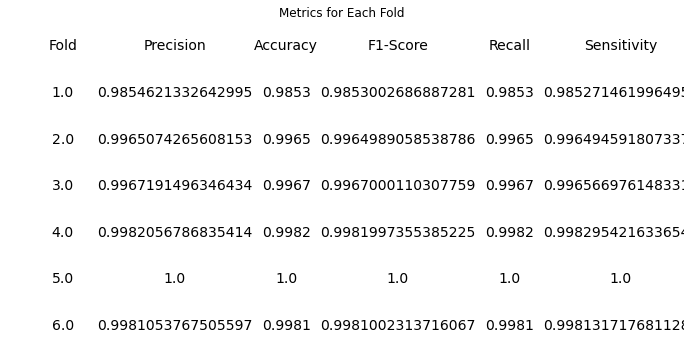

In [19]:
# Displaying the metrics in tabular format
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.axis('off')
table = plt.table(cellText=cv_results[['Fold', 'Precision', 'Accuracy', 'F1-Score', 'Recall', 'Sensitivity']].values,
                  colLabels=['Fold', 'Precision', 'Accuracy', 'F1-Score', 'Recall', 'Sensitivity'],
                  cellLoc='center', loc='center', bbox=[0, 0, 1, 1], colColours=['#f0f0f0']*6, edges='open', fontsize=14)  # Adjust the fontsize as needed
table.auto_set_font_size(False)
table.set_fontsize(14)  
plt.title("Metrics for Each Fold")
plt.show()

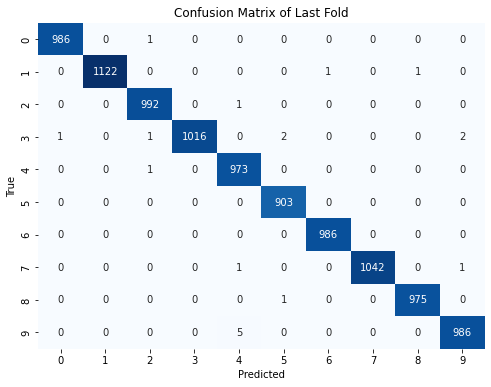

In [20]:
# Plotting the confusion matrix of the last fold as a heatmap
last_fold_confusion_matrix = cv_results.iloc[-1]['Confusion Matrix']
plt.figure(figsize=(8, 6))
sns.heatmap(last_fold_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix of Last Fold")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()